# Load the Configuration of YOLOs

<img src="https://colab.research.google.com/img/colab_favicon_256px.png" alt="Running on Colab" width='60'> [Runing on colab]()

**1. Import model from ultralytics framework (PyTorch)** :

Load the pre-trained YOLO model from the ultralytics library. This library provides development tools for the YOLO (You Only Look Once) series of computer vision models. You are allowed to select the currently validated Pose model in `model_name`.

In [1]:
!pip install ultralytics
from ultralytics import YOLO

model_name = "yolo11n.pt"   # @param ["yolov5nu.pt", "yolov5su.pt", "yolov5mu.pt", "yolov5lu.pt", "yolov5xu.pt", "yolov8n.pt", "yolov8s.pt", "yolov8m.pt", "yolov8l.pt", "yolov8x.pt", "yolo11n.pt", "yolo11s.pt", "yolo11m.pt", "yolo11l.pt", "yolo11x.pt"]
model = YOLO(model_name)

In [2]:
output_path = model.export(format='torchscript')
output_path

Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.4 MB)

TorchScript: starting export with torch 2.5.0+cu124...
TorchScript: export success ✅ 6.3s, saved as 'yolo11n.torchscript' (10.6 MB)

Export complete (8.3s)
Results saved to /content
Predict:         yolo predict task=detect model=yolo11n.torchscript imgsz=640  
Validate:        yolo val task=detect model=yolo11n.torchscript imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


'yolo11n.torchscript'

In [3]:
import torch

class YOLOs():
    def __init__(self, model_path, nc = 1, imgsz=(640, 640)):
        self.torch_model = torch.jit.load(model_path)
        self.X_axis = [0, 2]
        self.y_axis = [1, 3]
        self.nc = nc
        self.imgsz = imgsz

    def predict(self, frames, conf=0.25, iou=0.7, agnostic=False, max_det=300):
        im = self.preprocess(frames)
        preds = self.inference(im)

        results = self.postprocess(preds, conf_thres=conf, iou_thres=iou, agnostic=agnostic, max_det=max_det)
        return results

    def postprocess(self, preds, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False, labels=(), max_det=300, nc=0, max_time_img=0.05, max_nms=30000, max_wh=7680, in_place=True, rotated=False):
        xc = np.max(preds[:, 4: self.nc + 4], axis = 1) > conf_thres
        preds = np.transpose(preds, (0, 2, 1))
        preds[..., :4] = xywh2xyxy(preds[..., :4])
        x = preds[0][xc[0]]

        if not x.shape[0]:
          return None
        box, cls, keypoints = x[:, :4], x[:, 4:5], x[:, 5:]
        j = np.argmax(cls, axis=1)
        conf = cls[[i for i in range(len(j))], j]
        concatenated = np.concatenate((box, conf.reshape(-1, 1), j.reshape(-1, 1).astype(float), keypoints), axis=1)
        x = concatenated[conf.flatten() > conf_thres]

        if x.shape[0] > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]
        cls = x[:, 5:6] * (0 if agnostic else max_wh)
        scores, boxes = x[:, 4], x[:, :4] + cls

        i = non_max_suppression(boxes, scores, iou_thres)
        return [x[i[:max_det]]]

    def inference(self, im):
        with torch.no_grad():
          im = torch.from_numpy(im)
          preds = self.torch_model(im).numpy()
        return preds

    def preprocess(self, im):
        im = np.stack(self.pre_transform(im))
        im = im[..., ::-1]
        im = np.ascontiguousarray(im).astype(np.float32)
        im /= 255.0
        im = np.transpose(im, (0, 3, 1, 2))
        return im

    def pre_transform(self, im):
        return [cv2.resize(im[0], self.imgsz, interpolation=cv2.INTER_LINEAR) for x in im]

class LetterBox:
    def __init__(self, new_shape=(640, 640), auto=False, scaleFill=False, scaleup=True, center=True, stride=32):
        self.new_shape = new_shape
        self.auto = auto
        self.scaleFill = scaleFill
        self.scaleup = scaleup
        self.stride = stride
        self.center = center

    def __call__(self, labels=None, image=None):
        if labels is None:
            labels = {}
        img = labels.get("img") if image is None else image
        shape = img.shape[:2]
        new_shape = labels.pop("rect_shape", self.new_shape)
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not self.scaleup:
            r = min(r, 1.0)

        ratio = r, r
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if self.auto:
            dw, dh = np.mod(dw, self.stride), np.mod(dh, self.stride)  # wh padding
        elif self.scaleFill:
            dw, dh = 0.0, 0.0
            new_unpad = (new_shape[1], new_shape[0])
            ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

        if self.center:
            dw /= 2
            dh /= 2

        if shape[::-1] != new_unpad:
            img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)) if self.center else 0, int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)) if self.center else 0, int(round(dw + 0.1))
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))
        if labels.get("ratio_pad"):
            labels["ratio_pad"] = (labels["ratio_pad"], (left, top))  # for evaluation

        if len(labels):
            labels = self._update_labels(labels, ratio, dw, dh)
            labels["img"] = img
            labels["resized_shape"] = new_shape
            return labels
        else:
            return img

    def _update_labels(self, labels, ratio, padw, padh):
        labels["instances"].convert_bbox(format="xyxy")
        labels["instances"].denormalize(*labels["img"].shape[:2][::-1])
        labels["instances"].scale(*ratio)
        labels["instances"].add_padding(padw, padh)
        return labels

def plot(image, results, labels):
    for bboxes in results:
      x1, y1, x2, y2 = int(bboxes[0] * image.shape[1] / 640), int(bboxes[1] * image.shape[0] / 640), int(bboxes[2] * image.shape[1] / 640), int(bboxes[3] * image.shape[0] / 640)
      conf, cls = bboxes[4] , bboxes[5]
      cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=3)
      cv2.putText(image, f'{labels[int(cls)]} {conf:.2f}', (x1, y1 - 2), 0, 1, [0, 255, 0], thickness=2, lineType=cv2.LINE_AA)
    return image

def xywh2xyxy(x):
    assert x.shape[-1] == 4, f"input shape last dimension expected 4 but input shape is {x.shape}"
    y = np.empty_like(x)
    xy = x[..., :2]
    wh = x[..., 2:] / 2
    y[..., :2] = xy - wh
    y[..., 2:] = xy + wh
    return y

def non_max_suppression(boxes, scores, iou_threshold):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]

    return np.array(keep)

--2024-11-18 12:22:02--  https://ultralytics.com/images/bus.jpg
Resolving ultralytics.com (ultralytics.com)... 75.2.70.75, 99.83.190.102
Connecting to ultralytics.com (ultralytics.com)|75.2.70.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ultralytics.com/images/bus.jpg [following]
--2024-11-18 12:22:02--  https://www.ultralytics.com/images/bus.jpg
Resolving www.ultralytics.com (www.ultralytics.com)... 172.64.147.154, 104.18.40.102, 2606:4700:4400::6812:2866, ...
Connecting to www.ultralytics.com (www.ultralytics.com)|172.64.147.154|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ultralytics/assets/releases/download/v0.0.0/bus.jpg [following]
--2024-11-18 12:22:02--  https://github.com/ultralytics/assets/releases/download/v0.0.0/bus.jpg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request

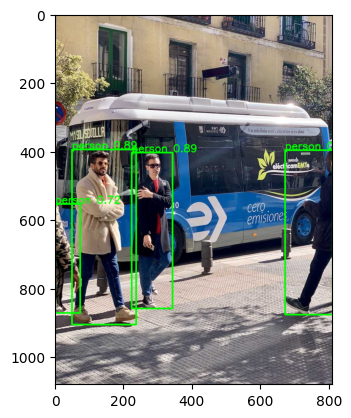

In [4]:
!wget https://ultralytics.com/images/bus.jpg -O bus.jpg
import torch, cv2
import numpy as np
import matplotlib.pyplot as plt

labels = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant',
      11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear',
      22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball',
      33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork',
      43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut',
      55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard',
      67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear',
      78: 'hair drier', 79: 'toothbrush'}

img = cv2.imread('./bus.jpg')
torch_model = YOLOs(model_path=output_path, imgsz=(640, 640))
results = torch_model.predict([img], conf=0.25, iou=0.7, agnostic=False, max_det=300)
plt.imshow(plot(img.copy(), results[0].copy(), labels)[:, :, ::-1])
plt.show()

In [5]:
import torch

torch_model = torch.jit.load(output_path)
input_tensor = torch.randn(1, 3, 640, 640)
print(input_tensor.shape)
print(input_tensor)
with torch.no_grad():
  output = torch_model(input_tensor)
output

torch.Size([1, 3, 640, 640])
tensor([[[[-1.0369,  1.7939,  1.1210,  ...,  1.7657, -0.9637,  0.6973],
          [ 0.2160,  0.1733,  0.3036,  ..., -0.7967,  0.9237, -1.2321],
          [ 1.0926,  0.6933, -1.0116,  ..., -0.0979,  1.8427,  0.1535],
          ...,
          [ 0.8375, -0.0449, -0.5526,  ...,  1.0721, -0.8703,  0.7816],
          [-1.0181,  0.9439,  0.6682,  ..., -1.1471,  1.5674,  0.0202],
          [-1.2442, -0.5528, -0.7807,  ..., -0.8017, -1.0473,  0.2188]],

         [[ 0.3508, -0.7600,  0.1824,  ..., -0.3746, -0.3651, -1.4258],
          [-1.0860,  1.7469, -2.2172,  ..., -0.8217,  0.9224, -1.7530],
          [ 1.0735, -0.1091, -0.5533,  ..., -1.0538,  0.2090,  0.1723],
          ...,
          [ 0.2992,  0.4803,  0.1117,  ..., -0.6020, -1.2403, -0.0111],
          [ 1.3277,  0.2385,  0.6985,  ..., -1.3814,  0.8662,  1.6613],
          [-1.4979,  0.1577, -0.3505,  ..., -0.5315,  1.6731,  0.3291]],

         [[ 0.4773, -0.4547,  0.0157,  ..., -1.0345,  0.0197,  1.9325],
 

tensor([[[5.0720e+00, 1.2043e+01, 3.4257e+01,  ..., 5.2809e+02, 5.4581e+02, 5.8210e+02],
         [4.2442e+00, 5.0587e+00, 7.1413e+00,  ..., 5.9550e+02, 5.8660e+02, 5.8134e+02],
         [9.8111e+00, 1.9362e+01, 7.1237e+01,  ..., 2.2632e+02, 1.9228e+02, 1.2320e+02],
         ...,
         [5.2028e-07, 1.8558e-07, 2.2900e-07,  ..., 1.1488e-06, 1.0321e-06, 1.6687e-06],
         [4.0278e-07, 1.8333e-07, 1.5814e-07,  ..., 1.3349e-06, 1.2068e-06, 1.4330e-06],
         [1.1685e-06, 4.5559e-07, 2.3762e-07,  ..., 1.2119e-06, 1.0659e-06, 1.4558e-06]]])

# Delegation

## KleidiAI

## HailoRT

**Step1.** Export to ONNX format with opset 11.

In [17]:
output_path = model.export(format='onnx', imgsz=640, opset=11)
output_path

Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.4 MB)

ONNX: starting export with onnx 1.17.0 opset 11...
ONNX: slimming with onnxslim 0.1.39...
ONNX: export success ✅ 2.3s, saved as 'yolo11n.onnx' (10.2 MB)

Export complete (3.0s)
Results saved to /content
Predict:         yolo predict task=detect model=yolo11n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolo11n.onnx imgsz=640 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app


'yolo11n.onnx'

**Step2.** Validate the accuracy


In [18]:
delegated_model = YOLO(output_path)
metrics = delegated_model.val(data="coco8.yaml")

print(metrics.box.map)  # mAP50-95
print(metrics.box.map50)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.0+cu124 CPU (Intel Xeon 2.20GHz)
Loading yolo11n.onnx for ONNX Runtime inference...
Preferring ONNX Runtime AzureExecutionProvider
Setting batch=1 input of shape (1, 3, 640, 640)


val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


                   all          4         17      0.846      0.637       0.85      0.608
                person          3         10          1      0.324      0.603      0.293
                   dog          1          1      0.724          1      0.995      0.697
                 horse          1          2      0.964          1      0.995      0.462
              elephant          1          2      0.672        0.5      0.518      0.307
              umbrella          1          1      0.719          1      0.995      0.995
          potted plant          1          1          1          0      0.995      0.895
Speed: 6.0ms preprocess, 407.1ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/val29
0.6082262589758726
0.850260337085477


**Step3.** Reproduce the output process manually.

In [19]:
import numpy as np

class YOLOs():
    def __init__(self, model_path, nc = 1):
        self.session = ort.InferenceSession(model_path)
        self.input_details  = [i for i in self.session.get_inputs()]
        self.output_details = [i.name for i in self.session.get_outputs()]
        self.X_axis = [0, 2]
        self.y_axis = [1, 3]
        self.nc = nc

    def predict(self, frames, conf=0.25, iou=0.7, agnostic=False, max_det=300):
        im = self.preprocess(frames)
        preds = self.inference(im)
        results = self.postprocess(preds, conf_thres=conf, iou_thres=iou, agnostic=agnostic, max_det=max_det)
        return results

    def postprocess(self, preds, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False, labels=(), max_det=300, nc=0, max_time_img=0.05, max_nms=30000, max_wh=7680, in_place=True, rotated=False):
        xc = np.max(preds[:, 4: self.nc + 4], axis = 1) > conf_thres
        preds = np.transpose(preds, (0, 2, 1))
        preds[..., :4] = xywh2xyxy(preds[..., :4])
        x = preds[0][xc[0]]

        if not x.shape[0]:
          return None
        box, cls, keypoints = x[:, :4], x[:, 4:5], x[:, 5:]
        j = np.argmax(cls, axis=1)
        conf = cls[[i for i in range(len(j))], j]
        concatenated = np.concatenate((box, conf.reshape(-1, 1), j.reshape(-1, 1).astype(float), keypoints), axis=1)
        x = concatenated[conf.flatten() > conf_thres]

        if x.shape[0] > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]
        cls = x[:, 5:6] * (0 if agnostic else max_wh)
        scores, boxes = x[:, 4], x[:, :4] + cls

        i = non_max_suppression(boxes, scores, iou_thres)
        return [x[i[:max_det]]]

    def inference(self, im):
        inputs = {key.name: value for key, value in zip(self.input_details, [im])}
        preds = self.session.run(self.output_details, inputs)[0]
        return preds

    def preprocess(self, im):
        im = np.stack(self.pre_transform(im))
        im = im[..., ::-1]
        im = np.ascontiguousarray(im).astype(np.float32)
        im /= 255.0
        im = np.transpose(im, (0, 3, 1, 2))
        return im

    def pre_transform(self, im):
        imgsz = self.input_details[0].shape[2:]
        return [cv2.resize(im[0], imgsz, interpolation=cv2.INTER_LINEAR) for x in im]

class LetterBox:
    def __init__(self, new_shape=(640, 640), auto=False, scaleFill=False, scaleup=True, center=True, stride=32):
        self.new_shape = new_shape
        self.auto = auto
        self.scaleFill = scaleFill
        self.scaleup = scaleup
        self.stride = stride
        self.center = center

    def __call__(self, labels=None, image=None):
        if labels is None:
            labels = {}
        img = labels.get("img") if image is None else image
        shape = img.shape[:2]
        new_shape = labels.pop("rect_shape", self.new_shape)
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not self.scaleup:
            r = min(r, 1.0)

        ratio = r, r
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if self.auto:
            dw, dh = np.mod(dw, self.stride), np.mod(dh, self.stride)  # wh padding
        elif self.scaleFill:
            dw, dh = 0.0, 0.0
            new_unpad = (new_shape[1], new_shape[0])
            ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

        if self.center:
            dw /= 2
            dh /= 2

        if shape[::-1] != new_unpad:
            img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)) if self.center else 0, int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)) if self.center else 0, int(round(dw + 0.1))
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))
        if labels.get("ratio_pad"):
            labels["ratio_pad"] = (labels["ratio_pad"], (left, top))  # for evaluation

        if len(labels):
            labels = self._update_labels(labels, ratio, dw, dh)
            labels["img"] = img
            labels["resized_shape"] = new_shape
            return labels
        else:
            return img

    def _update_labels(self, labels, ratio, padw, padh):
        labels["instances"].convert_bbox(format="xyxy")
        labels["instances"].denormalize(*labels["img"].shape[:2][::-1])
        labels["instances"].scale(*ratio)
        labels["instances"].add_padding(padw, padh)
        return labels

def plot(image, results, labels):
    for bboxes in results:
      x1, y1, x2, y2 = int(bboxes[0] * image.shape[1] / 640), int(bboxes[1] * image.shape[0] / 640), int(bboxes[2] * image.shape[1] / 640), int(bboxes[3] * image.shape[0] / 640)
      conf, cls = bboxes[4] , bboxes[5]
      cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=3)
      cv2.putText(image, f'{labels[int(cls)]} {conf:.2f}', (x1, y1 - 2), 0, 1, [0, 255, 0], thickness=2, lineType=cv2.LINE_AA)
    return image

def xywh2xyxy(x):
    assert x.shape[-1] == 4, f"input shape last dimension expected 4 but input shape is {x.shape}"
    y = np.empty_like(x)
    xy = x[..., :2]
    wh = x[..., 2:] / 2
    y[..., :2] = xy - wh
    y[..., 2:] = xy + wh
    return y

def non_max_suppression(boxes, scores, iou_threshold):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]

    return np.array(keep)

--2024-11-18 12:23:54--  https://ultralytics.com/images/bus.jpg
Resolving ultralytics.com (ultralytics.com)... 99.83.190.102, 75.2.70.75
Connecting to ultralytics.com (ultralytics.com)|99.83.190.102|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ultralytics.com/images/bus.jpg [following]
--2024-11-18 12:23:54--  https://www.ultralytics.com/images/bus.jpg
Resolving www.ultralytics.com (www.ultralytics.com)... 172.64.147.154, 104.18.40.102, 2606:4700:4400::ac40:939a, ...
Connecting to www.ultralytics.com (www.ultralytics.com)|172.64.147.154|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ultralytics/assets/releases/download/v0.0.0/bus.jpg [following]
--2024-11-18 12:23:54--  https://github.com/ultralytics/assets/releases/download/v0.0.0/bus.jpg
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP requ

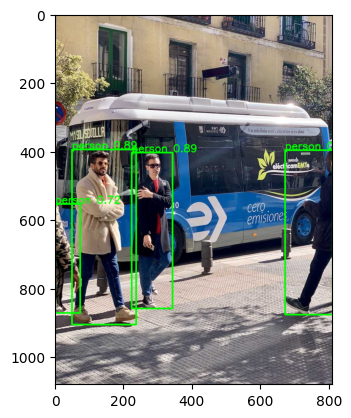

In [20]:
!wget https://ultralytics.com/images/bus.jpg -O bus.jpg
import onnxruntime as ort
import matplotlib.pyplot as plt
import cv2

labels = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant',
      11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear',
      22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball',
      33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork',
      43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut',
      55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard',
      67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear',
      78: 'hair drier', 79: 'toothbrush'}

img = cv2.imread('./bus.jpg')
onnx_model = YOLOs(model_path=output_path)
results = onnx_model.predict([img], conf=0.25, iou=0.7, agnostic=False, max_det=300)

plt.imshow(plot(img.copy(), results[0].copy(), labels)[:, :, ::-1])
plt.show()

## Export to Others

**Step1.** Export to TFLite format.

In [10]:
output_path = model.export(format='tflite', imgsz=640)
output_path

Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (5.4 MB)

TensorFlow SavedModel: starting export with tensorflow 2.17.1...

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.39...
ONNX: export success ✅ 1.8s, saved as 'yolo11n.onnx' (10.3 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 39.7s, saved as 'yolo11n_saved_model' (26.0 MB)

TensorFlow Lite: starting export with tensorflow 2.17.1...
TensorFlow Lite: export success ✅ 0.0s, saved as 'yolo11n_saved_model/yolo11n_float32.tflite' (10.3 MB)

Export complete (40.4s)
Results saved to /content
Predict:         yolo predict task=detect model=yolo11n_saved_model/yolo11n_float32.tflite imgsz=640  
Validate:        yolo va

'yolo11n_saved_model/yolo11n_float32.tflite'

**Step2.** Validate the accuracy

In [11]:
delegated_model = YOLO(output_path)
metrics = delegated_model.val(data="coco8.yaml")

print(metrics.box.map)  # mAP50-95
print(metrics.box.map50)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.0+cu124 CPU (Intel Xeon 2.20GHz)
Loading yolo11n_saved_model/yolo11n_float32.tflite for TensorFlow Lite inference...
Setting batch=1 input of shape (1, 3, 640, 640)


val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


                   all          4         17      0.846      0.637       0.85      0.608
                person          3         10          1      0.324      0.603      0.293
                   dog          1          1      0.724          1      0.995      0.697
                 horse          1          2      0.964          1      0.995      0.462
              elephant          1          2      0.672        0.5      0.518      0.307
              umbrella          1          1      0.719          1      0.995      0.995
          potted plant          1          1          1          0      0.995      0.895
Speed: 2.4ms preprocess, 168.9ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val27
0.6082262589758726
0.850260337085477


In [12]:
delegated_model = YOLO(output_path.replace('float32', 'float16'))
metrics = delegated_model.val(data="coco8.yaml")

print(metrics.box.map)  # mAP50-95
print(metrics.box.map50)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.0+cu124 CPU (Intel Xeon 2.20GHz)
Loading yolo11n_saved_model/yolo11n_float16.tflite for TensorFlow Lite inference...
Setting batch=1 input of shape (1, 3, 640, 640)


val: Scanning /content/datasets/coco8/labels/val.cache... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


                   all          4         17      0.846      0.637      0.851       0.61
                person          3         10          1      0.324      0.606      0.294
                   dog          1          1      0.722          1      0.995      0.697
                 horse          1          2      0.968          1      0.995      0.473
              elephant          1          2      0.665        0.5      0.518      0.307
              umbrella          1          1      0.719          1      0.995      0.995
          potted plant          1          1          1          0      0.995      0.895
Speed: 2.6ms preprocess, 169.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/val28
0.6101123036361672
0.8507484562541895


**Step3.** Reproduce the output process manually.

In [13]:
import numpy as np

class YOLOs():
    def __init__(self, model_path, nc = 1):
        self.interpreter = tf_lite.Interpreter(model_path=model_path)
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.interpreter.allocate_tensors()
        self.X_axis = [0, 2]
        self.y_axis = [1, 3]
        self.nc = nc

    def predict(self, frames, conf=0.25, iou=0.7, agnostic=False, max_det=300):
        im = self.preprocess(frames)
        preds = self.inference(im)
        results = self.postprocess(preds, conf_thres=conf, iou_thres=iou, agnostic=agnostic, max_det=max_det)
        return results

    def postprocess(self, preds, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False, labels=(), max_det=300, nc=0, max_time_img=0.05, max_nms=30000, max_wh=7680, in_place=True, rotated=False):
        xc = np.max(preds[:, 4: self.nc + 4], axis = 1) > conf_thres
        preds = np.transpose(preds, (0, 2, 1))
        preds[..., :4] = xywh2xyxy(preds[..., :4])
        x = preds[0][xc[0]]

        if not x.shape[0]:
          return None
        box, cls, keypoints = x[:, :4], x[:, 4:5], x[:, 5:]
        j = np.argmax(cls, axis=1)
        conf = cls[[i for i in range(len(j))], j]
        concatenated = np.concatenate((box, conf.reshape(-1, 1), j.reshape(-1, 1).astype(float), keypoints), axis=1)
        x = concatenated[conf.flatten() > conf_thres]

        if x.shape[0] > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]
        cls = x[:, 5:6] * (0 if agnostic else max_wh)
        scores, boxes = x[:, 4], x[:, :4] + cls

        i = non_max_suppression(boxes, scores, iou_thres)
        return [x[i[:max_det]]]

    def inference(self, im):
        self.interpreter.set_tensor(self.input_details[0]['index'], im)
        self.interpreter.invoke()
        preds = self.interpreter.get_tensor(self.output_details[0]['index'])
        preds[:, self.X_axis] *= im.shape[1] ; preds[:, self.y_axis] *= im.shape[2]
        return preds

    def preprocess(self, im):
        im = np.stack(self.pre_transform(im))
        im = im[..., ::-1]
        im = np.ascontiguousarray(im).astype(np.float32)
        im /= 255.0
        return im

    def pre_transform(self, im):
        imgsz = self.input_details[0]['shape'][1:3]
        return [cv2.resize(im[0], imgsz, interpolation=cv2.INTER_LINEAR) for x in im]

class LetterBox:
    def __init__(self, new_shape=(640, 640), auto=False, scaleFill=False, scaleup=True, center=True, stride=32):
        self.new_shape = new_shape
        self.auto = auto
        self.scaleFill = scaleFill
        self.scaleup = scaleup
        self.stride = stride
        self.center = center

    def __call__(self, labels=None, image=None):
        if labels is None:
            labels = {}
        img = labels.get("img") if image is None else image
        shape = img.shape[:2]
        new_shape = labels.pop("rect_shape", self.new_shape)
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not self.scaleup:
            r = min(r, 1.0)

        ratio = r, r
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if self.auto:
            dw, dh = np.mod(dw, self.stride), np.mod(dh, self.stride)  # wh padding
        elif self.scaleFill:
            dw, dh = 0.0, 0.0
            new_unpad = (new_shape[1], new_shape[0])
            ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

        if self.center:
            dw /= 2
            dh /= 2

        if shape[::-1] != new_unpad:
            img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)) if self.center else 0, int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)) if self.center else 0, int(round(dw + 0.1))
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))
        if labels.get("ratio_pad"):
            labels["ratio_pad"] = (labels["ratio_pad"], (left, top))  # for evaluation

        if len(labels):
            labels = self._update_labels(labels, ratio, dw, dh)
            labels["img"] = img
            labels["resized_shape"] = new_shape
            return labels
        else:
            return img

    def _update_labels(self, labels, ratio, padw, padh):
        labels["instances"].convert_bbox(format="xyxy")
        labels["instances"].denormalize(*labels["img"].shape[:2][::-1])
        labels["instances"].scale(*ratio)
        labels["instances"].add_padding(padw, padh)
        return labels

def plot(image, results, labels):
    for bboxes in results:
      x1, y1, x2, y2 = int(bboxes[0] * image.shape[1] / 640), int(bboxes[1] * image.shape[0] / 640), int(bboxes[2] * image.shape[1] / 640), int(bboxes[3] * image.shape[0] / 640)
      conf, cls = bboxes[4] , bboxes[5]
      cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=3)
      cv2.putText(image, f'{labels[int(cls)]} {conf:.2f}', (x1, y1 - 2), 0, 1, [0, 255, 0], thickness=2, lineType=cv2.LINE_AA)
    return image

def xywh2xyxy(x):
    assert x.shape[-1] == 4, f"input shape last dimension expected 4 but input shape is {x.shape}"
    y = np.empty_like(x)
    xy = x[..., :2]
    wh = x[..., 2:] / 2
    y[..., :2] = xy - wh
    y[..., 2:] = xy + wh
    return y

def non_max_suppression(boxes, scores, iou_threshold):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]

    return np.array(keep)

--2024-11-18 12:23:23--  https://ultralytics.com/images/bus.jpg
Resolving ultralytics.com (ultralytics.com)... 75.2.70.75, 99.83.190.102
Connecting to ultralytics.com (ultralytics.com)|75.2.70.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ultralytics.com/images/bus.jpg [following]
--2024-11-18 12:23:23--  https://www.ultralytics.com/images/bus.jpg
Resolving www.ultralytics.com (www.ultralytics.com)... 104.18.40.102, 172.64.147.154, 2606:4700:4400::6812:2866, ...
Connecting to www.ultralytics.com (www.ultralytics.com)|104.18.40.102|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ultralytics/assets/releases/download/v0.0.0/bus.jpg [following]
--2024-11-18 12:23:23--  https://github.com/ultralytics/assets/releases/download/v0.0.0/bus.jpg
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request 

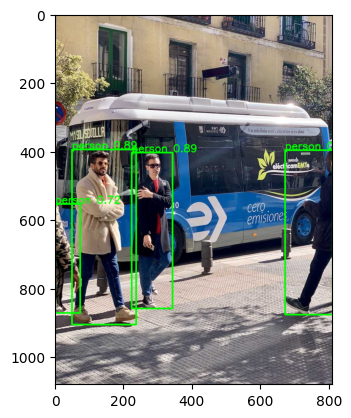

In [14]:
!wget https://ultralytics.com/images/bus.jpg -O bus.jpg
import tensorflow.lite as tf_lite
import matplotlib.pyplot as plt
import cv2

labels = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant',
      11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear',
      22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball',
      33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork',
      43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut',
      55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard',
      67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear',
      78: 'hair drier', 79: 'toothbrush'}

img = cv2.imread('./bus.jpg')
tflite_model = YOLOs(model_path=output_path)
results = tflite_model.predict([img], conf=0.25, iou=0.7, agnostic=False, max_det=300)

plt.imshow(plot(img.copy(), results[0].copy(), labels)[:, :, ::-1])
plt.show()